In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import keras as ks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, Callback
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/felix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/felix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/felix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# read data

In [2]:
df = pd.read_json (r'./corpora-DO_NOT_SHARE/unified-dataset.json', lines=True)

In [3]:
df['source'].unique()

array(['tec', 'ssec', 'dailydialogues', 'fb-valence-arousal-anon',
       'affectivetext', 'emotiondata-aman', 'electoraltweets',
       'grounded_emotions', 'emotion-cause', 'isear', 'emoint',
       'crowdflower', 'tales-emotion'], dtype=object)

In [4]:
# select only needed sources
df = df.loc[(df['source'] == "tec") | (df['source'] == "crowdflower")]

In [5]:
# remove not needed columns
df = df.drop(columns=['id', 'VAD', 'split', 'domain', 'labeled', 'optional', 'annotation_procedure', 'emotion_model'])

In [6]:
# convert emotions dict to columns
df = df.join(df['emotions'].apply(pd.Series))

In [7]:
# remove not needed columns
df = df.drop(columns=['emotions', 'trust', 'love', 'noemo', 'confusion', 'anticipation', 'shame', 'guilt', 'anticipation'])

In [8]:
# remove not annotated texts
df = df.loc[(df['joy'] != 0) | (df['anger'] != 0) | (df['sadness'] != 0) | (df['disgust'] != 0) | (df['fear'] != 0) | (df['surprise'] != 0)]

In [9]:
# remove stop words except not and but
stop_words = set(stopwords.words('english')) - {"not", "but"}
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

# preprocessing

In [10]:
embeddings_index = {}

num_words = 10000
maxlen = df.text.str.split().apply(len).max()
embedding_dim = 100

In [11]:
df.columns

Index(['source', 'text', 'joy', 'anger', 'sadness', 'disgust', 'fear',
       'surprise'],
      dtype='object')

In [12]:
#data_source = df
#data_source = df.loc[(df['source'] == "tec")]
data_source = df.loc[(df['source'] == "crowdflower")]

## lemmatize

In [13]:
def getLemmText(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)
data_source['text'] = data_source['text'].apply(getLemmText)

<ipython-input-13-cb4ac0dcb796>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source['text'] = data_source['text'].apply(getLemmText)


## stemming

In [14]:
def getStemmText(text):
    tokens = word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)
data_source['text'] = data_source['text'].apply(getStemmText)

<ipython-input-14-0088c70619d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source['text'] = data_source['text'].apply(getStemmText)


## pading

In [15]:
# select x and y
samples = data_source['text']
labels = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index

padded_sequences = sequence.pad_sequences(sequences, maxlen, padding='post')

## embedding

In [16]:
f = open("glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# data split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.33, random_state=42)

In [20]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = dict(enumerate(class_weights))

/nix/store/5kig4h8sfvswwqkmzzq2fvkq31agvhww-python3-3.8.5-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 2 4 ... 4 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
print("Distribution of train-classes: ")
_, idx, count = np.unique(y_train.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_train[idx],count)})

Distribution of train-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 6156, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 958, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 3428, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 124, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 5650, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 1472}


In [22]:
class_weights

{0: 0.48158977691141436,
 1: 3.0946416144746,
 2: 0.8648385842084791,
 3: 23.908602150537636,
 4: 0.5247197640117994,
 5: 2.014039855072464}

# model training

In [23]:
# ["conv", "lstm", "simple"]
method = "lstm"

In [24]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
if method == "simple":
    pass
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(14))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
if method == "conv":
    pass
    model.add(Conv1D(64, (3)))
    model.add(Conv1D(32, (3)))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Flatten())
if method == "lstm":
    pass
    model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

#regularizer backup
# model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Conv1D(32, (3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Bidirectional(LSTM(32)))#, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

#optimizer = Adam(learning_rate=0.0005)
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train,
                    y_train,
                    epochs=250,
                    batch_size=100,
                    validation_data=(x_test,y_test),
                    class_weight=class_weights,
                    callbacks=[
                        ReduceLROnPlateau(monitor='accuracy',
                                          patience=10,
                                          verbose=1,
                                          factor=0.9,
                                          min_lr=0.00001)
                    ])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                14976     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 1,015,174
Trainable params: 15,174
Non-trainable params: 1,000,000
_________________________________________________________________
None
Epoch 1/250
178/178 [==============================] - 5s 26ms/step - loss: 1.8222 - accuracy: 0.2433 - val_loss: 1.7572 - val_accuracy: 0.2616
Epoch 2/250
178/178 [==============================] - 4s 20ms/step - loss: 1.8128 - accur

178/178 [==============================] - 4s 20ms/step - loss: 1.5746 - accuracy: 0.3470 - val_loss: 1.5898 - val_accuracy: 0.3578
Epoch 52/250
178/178 [==============================] - 4s 24ms/step - loss: 1.5695 - accuracy: 0.3438 - val_loss: 1.6031 - val_accuracy: 0.3528
Epoch 53/250
178/178 [==============================] - 4s 21ms/step - loss: 1.5577 - accuracy: 0.3429 - val_loss: 1.6024 - val_accuracy: 0.3524
Epoch 54/250
178/178 [==============================] - 4s 20ms/step - loss: 1.5542 - accuracy: 0.3450 - val_loss: 1.6012 - val_accuracy: 0.3504
Epoch 55/250
178/178 [==============================] - 4s 20ms/step - loss: 1.5598 - accuracy: 0.3452 - val_loss: 1.6172 - val_accuracy: 0.3363
Epoch 56/250
178/178 [==============================] - 4s 20ms/step - loss: 1.5533 - accuracy: 0.3424 - val_loss: 1.6353 - val_accuracy: 0.3304
Epoch 57/250
178/178 [==============================] - 4s 20ms/step - loss: 1.5504 - accuracy: 0.3370 - val_loss: 1.5806 - val_accuracy: 0.352

178/178 [==============================] - 4s 20ms/step - loss: 1.4069 - accuracy: 0.3570 - val_loss: 1.5488 - val_accuracy: 0.3570
Epoch 107/250
178/178 [==============================] - 3s 19ms/step - loss: 1.4080 - accuracy: 0.3621 - val_loss: 1.5335 - val_accuracy: 0.3668
Epoch 108/250
178/178 [==============================] - 4s 20ms/step - loss: 1.3996 - accuracy: 0.3630 - val_loss: 1.5587 - val_accuracy: 0.3596
Epoch 109/250
178/178 [==============================] - 3s 20ms/step - loss: 1.4021 - accuracy: 0.3636 - val_loss: 1.5606 - val_accuracy: 0.3596
Epoch 110/250
178/178 [==============================] - 4s 21ms/step - loss: 1.3939 - accuracy: 0.3584 - val_loss: 1.5365 - val_accuracy: 0.3604
Epoch 111/250
178/178 [==============================] - 4s 21ms/step - loss: 1.3924 - accuracy: 0.3640 - val_loss: 1.5333 - val_accuracy: 0.3634
Epoch 112/250
178/178 [==============================] - 4s 20ms/step - loss: 1.3877 - accuracy: 0.3660 - val_loss: 1.5448 - val_accuracy:

Epoch 160/250
178/178 [==============================] - 3s 17ms/step - loss: 1.3011 - accuracy: 0.3787 - val_loss: 1.5082 - val_accuracy: 0.3726
Epoch 161/250
178/178 [==============================] - 3s 17ms/step - loss: 1.3070 - accuracy: 0.3750 - val_loss: 1.5186 - val_accuracy: 0.3697
Epoch 162/250
178/178 [==============================] - 3s 17ms/step - loss: 1.3066 - accuracy: 0.3779 - val_loss: 1.5266 - val_accuracy: 0.3661
Epoch 163/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2999 - accuracy: 0.3800 - val_loss: 1.5348 - val_accuracy: 0.3669
Epoch 164/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2978 - accuracy: 0.3737 - val_loss: 1.5249 - val_accuracy: 0.3701
Epoch 165/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2973 - accuracy: 0.3785 - val_loss: 1.5179 - val_accuracy: 0.3700
Epoch 166/250
178/178 [==============================] - 3s 17ms/step - loss: 1.3024 - accuracy: 0.3775 - val_loss: 1.5094 -

Epoch 215/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2453 - accuracy: 0.3841 - val_loss: 1.5133 - val_accuracy: 0.3738
Epoch 216/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2442 - accuracy: 0.3831 - val_loss: 1.5198 - val_accuracy: 0.3681
Epoch 217/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2433 - accuracy: 0.3865 - val_loss: 1.5084 - val_accuracy: 0.3723
Epoch 218/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2378 - accuracy: 0.3815 - val_loss: 1.5260 - val_accuracy: 0.3677
Epoch 219/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2455 - accuracy: 0.3837 - val_loss: 1.5091 - val_accuracy: 0.3701
Epoch 220/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2399 - accuracy: 0.3864 - val_loss: 1.5206 - val_accuracy: 0.3722
Epoch 221/250
178/178 [==============================] - 3s 17ms/step - loss: 1.2439 - accuracy: 0.3880 - val_loss: 1.5155 -

In [25]:
def nn_predict_single(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
    model_output = model.predict(padded_seq)
    return np.argmax(model_output)
def nn_predict_many(texts):
    lst = []
    for row in texts:
        seq = tokenizer.texts_to_sequences([row])
        padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
        lst.append(padded_seq)
    model_output = model.predict(np.vstack(lst))
    return np.argmax(model_output, axis=1)

# history plot

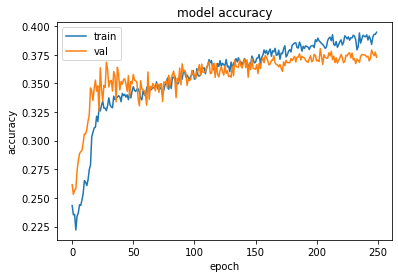

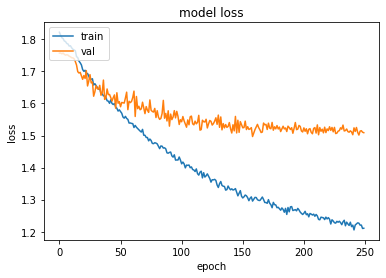

In [26]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(method + "_accuracy.png", transparent=False, pad_inches=0.1,  dpi=500)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(method + "_loss.png", transparent=False, pad_inches=0.1,  dpi=500)
plt.show()

# scores

In [27]:
from collections import Counter

correct = 0

#data_source = df
data_source = df.loc[(df['source'] == "tec")]
#data_source = df.loc[(df['source'] == "crowdflower")]

data_source['text'] = data_source['text'].apply(getLemmText)
data_source['text'] = data_source['text'].apply(getStemmText)

val_texts = data_source['text']
y_true = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

print("Distribution of test-classes: ")
_, idx, count = np.unique(y_true.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_true[idx],count)})

y_pred = []
# convert one-hot to sequence array
y_true = y_true.argmax(axis=1)

predictions = nn_predict_many(val_texts)
print(predictions)
for i in range(0,len(val_texts)):
    y_pred.append(predictions[i])
    if predictions[i] == y_true[i]:
        correct += 1
y_pred = np.array(y_pred)

<ipython-input-27-bb5f5f47c635>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source['text'] = data_source['text'].apply(getLemmText)
<ipython-input-27-bb5f5f47c635>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_source['text'] = data_source['text'].apply(getStemmText)


Distribution of test-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 8237, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1555, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 3830, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 761, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 2816, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 3849}
[0 5 0 ... 0 0 0]


In [28]:
# convert to strings
emotions = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']
y_true = [emotions[x] for x in y_true]
y_pred = [emotions[x] for x in y_pred]

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print("Accuracy:")
print(correct/len(val_texts))
print("F1 score micro")
print(f1_score(y_true, y_pred, average="micro"))
print("F1 score macro")
print(f1_score(y_true, y_pred, average="macro"))

# Look at class wise score
print(classification_report(y_true, y_pred))

result = ""
result += "Accuracy:" + str(correct/len(val_texts)) + "\n"
result += "F1 score micro:" + str(f1_score(y_true, y_pred, average="micro")) + "\n"
result += "F1 score macro:" + str(f1_score(y_true, y_pred, average="macro")) + "\n"
result += classification_report(y_true, y_pred) + "\n"
with open(method + "_result.txt", "w") as text_file:
    text_file.write(result)

Accuracy:
0.3370866590649943
F1 score micro
0.3370866590649943
F1 score macro
0.2546910833751695
              precision    recall  f1-score   support

       anger       0.21      0.26      0.23      1555
     disgust       0.03      0.01      0.01       761
        fear       0.19      0.22      0.21      2816
         joy       0.55      0.44      0.49      8237
     sadness       0.27      0.31      0.29      3830
    surprise       0.28      0.32      0.30      3849

    accuracy                           0.34     21048
   macro avg       0.25      0.26      0.25     21048
weighted avg       0.36      0.34      0.34     21048



# confusion matrix

<ipython-input-30-f472bd7ae910>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+tags)
<ipython-input-30-f472bd7ae910>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+tags)


<Figure size 432x288 with 0 Axes>

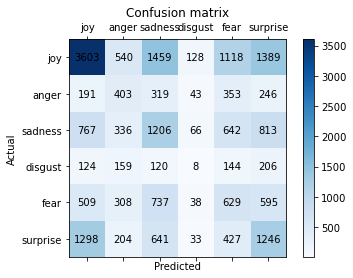

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tags = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']

cm = confusion_matrix(y_true,y_pred, labels = tags)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.matshow(cm, cmap=cmap)
    fig.colorbar(im)
    plt.title(title)
    ax.set_xticklabels([""]+tags)
    ax.set_yticklabels([""]+tags)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, z, ha='center', va='center')
    plt.savefig(method + "_conf.png", bbox_inches='tight', transparent=False, pad_inches=0.1,  dpi=500)
    plt.show()

# Compute confusion matrix
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)